In [1]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('BDAS').getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/10 07:08:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
#BU: Predict what individual values as happiness based on demographic attribute

In [3]:
#DU
#Read in the data
df_demog=spark.read.csv('BDAS_Iteration_Dataset/demographic.csv', header=True)
df_happy=spark.read.csv('BDAS_Iteration_Dataset/cleaned_hm.csv', header=True)

In [4]:
df_demog.show()
df_happy.show()

+---+----+-------+------+--------+----------+
|wid| age|country|gender| marital|parenthood|
+---+----+-------+------+--------+----------+
|  1|37.0|    USA|     m| married|         y|
|  2|29.0|    IND|     m| married|         y|
|  3|  25|    IND|     m|  single|         n|
|  4|  32|    USA|     m| married|         y|
|  5|  29|    USA|     m| married|         y|
|  6|  35|    IND|     m| married|         y|
|  7|  34|    USA|     m| married|         y|
|  8|  29|    VNM|     m|  single|         n|
|  9|  61|    USA|     f| married|         y|
| 10|  27|    USA|     m|  single|         n|
| 11|45.0|    USA|     m|divorced|         n|
| 12|  25|    USA|     f|  single|         n|
| 13|45.0|    IND|     m| married|         y|
| 14|25.0|    IND|     m| married|         y|
| 15|  27|    USA|     m| married|         y|
| 16|35.0|    USA|     m|  single|         n|
| 17|30.0|    USA|     m|  single|         n|
| 18|  30|    USA|     m|  single|         n|
| 19|  29|    USA|     m| married|

In [5]:
#Loading modified version of happy moment data set after seeing that the file cannot be properly read by spark
df_happy=spark.read.csv('BDAS_Iteration_Dataset/cleaned_hm_01.csv', header=True)
df_happy.show()

+----+------------------+
| wid|predicted_category|
+----+------------------+
|2053|         affection|
|   2|         affection|
|1936|          exercise|
| 206|           bonding|
|6227|         affection|
|  45|           leisure|
| 195|       achievement|
| 740|         affection|
|   3|  enjoy_the_moment|
|4833|         affection|
|7334|           leisure|
|  78|          exercise|
|  21|           bonding|
|   8|       achievement|
| 586|  enjoy_the_moment|
| 489|         affection|
| 976|           bonding|
|3972|       achievement|
|  14|           bonding|
|1230|         affection|
+----+------------------+
only showing top 20 rows



In [6]:
import pyspark.sql.functions as F

In [7]:
gender_counts = df_demog.groupBy('gender').count().orderBy('count', ascending=False)

In [8]:
gender_counts.show()

+------+-----+
|gender|count|
+------+-----+
|     f| 5445|
|     m| 5311|
|     o|   56|
|  null|   32|
+------+-----+



In [9]:
import pandas as pd
import matplotlib.pyplot as plt

TypeError: 'value' must be an instance of str or bytes, not a None

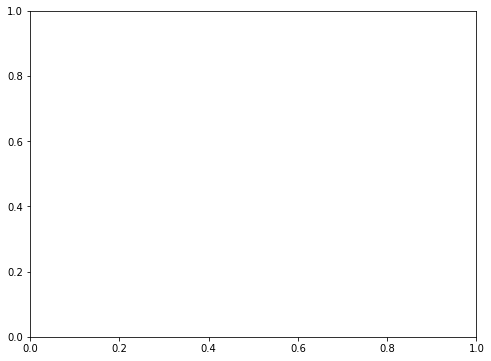

In [10]:
# Convert the PySpark DataFrame to a Pandas DataFrame & Create Visualization
gender_counts_pandas = gender_counts.toPandas()
plt.figure(figsize=(8, 6))
plt.bar(gender_counts_pandas['gender'], gender_counts_pandas['count'])
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Bar Chart of Gender Distribution')
plt.show()

In [11]:
# Convert the PySpark DataFrame to a Pandas DataFrame
gender_counts_pandas = gender_counts.dropna(subset=['gender']).toPandas()

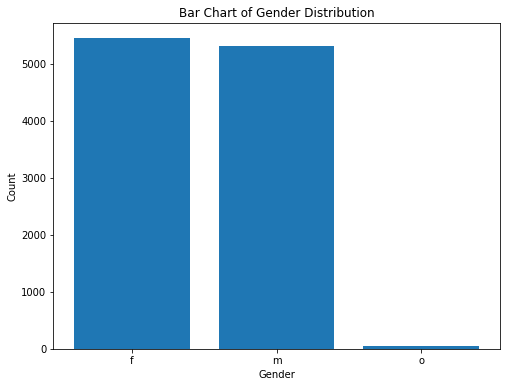

In [12]:
# Create a bar chart using Matplotlib
plt.figure(figsize=(8, 6))
plt.bar(gender_counts_pandas['gender'], gender_counts_pandas['count'])
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Bar Chart of Gender Distribution')
plt.show()

In [13]:
#Noticing that the visualization cannot be created with the missing value so, the cleaning process has to take place now

from pyspark.sql.functions import col

# Check for NA responses in df_demog
missing_demog = df_demog.select([F.count(F.when(col(c).isNull() | (col(c) == ''), c)).alias(c) for c in df_demog.columns])
missing_demog.show()

+---+---+-------+------+-------+----------+
|wid|age|country|gender|marital|parenthood|
+---+---+-------+------+-------+----------+
|  0| 35|     73|    32|     57|        31|
+---+---+-------+------+-------+----------+



In [17]:
# Check for NA responses in df_happy
missing_happy = df_happy.select([F.count(F.when(col(c).isNull() | (col(c) == ''), c)).alias(c) for c in df_happy.columns])
missing_happy.show()

+---+------------------+
|wid|predicted_category|
+---+------------------+
|  0|                 0|
+---+------------------+



In [18]:
# Count the number of responses in df_demog
count_demog = df_demog.count()
print("Number of responses in df_demog:", count_demog)

Number of responses in df_demog: 10844


In [19]:
# Count the number of responses in df_happy
count_happy = df_happy.count()
print("Number of responses in df_happy:", count_happy)

Number of responses in df_happy: 100535


In [20]:
# Since the Happy DataFrame does not contain any missing values, we can convert it to a Pandas DataFrame and explore
df_happy_pd = df_happy.toPandas()

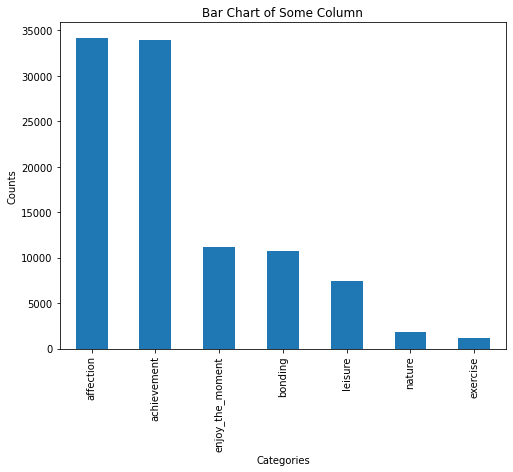

In [21]:
plt.figure(figsize=(8, 6))
df_happy_pd['predicted_category'].value_counts().plot(kind='bar')
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.title('Bar Chart of Some Column')
plt.show()

In [23]:
# Drop rows with missing data in df_demog
df_demog_cleaned = df_demog.dropna()

# Show the cleaned DataFrame
df_demog_cleaned.show()

+---+----+-------+------+--------+----------+
|wid| age|country|gender| marital|parenthood|
+---+----+-------+------+--------+----------+
|  1|37.0|    USA|     m| married|         y|
|  2|29.0|    IND|     m| married|         y|
|  3|  25|    IND|     m|  single|         n|
|  4|  32|    USA|     m| married|         y|
|  5|  29|    USA|     m| married|         y|
|  6|  35|    IND|     m| married|         y|
|  7|  34|    USA|     m| married|         y|
|  8|  29|    VNM|     m|  single|         n|
|  9|  61|    USA|     f| married|         y|
| 10|  27|    USA|     m|  single|         n|
| 11|45.0|    USA|     m|divorced|         n|
| 12|  25|    USA|     f|  single|         n|
| 13|45.0|    IND|     m| married|         y|
| 14|25.0|    IND|     m| married|         y|
| 15|  27|    USA|     m| married|         y|
| 16|35.0|    USA|     m|  single|         n|
| 17|30.0|    USA|     m|  single|         n|
| 18|  30|    USA|     m|  single|         n|
| 19|  29|    USA|     m| married|

In [24]:
# Count the number of responses in df_demog
count_demog_cleaned = df_demog_cleaned.count()
print("Number of responses in df_demog:", count_demog_cleaned)

Number of responses in df_demog: 10689
